In [1]:
import numpy as np
import numpy.matlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler 

In [2]:
game_data = pd.read_csv('games.csv')

In [3]:
print(game_data.columns)
game_data.head(1)

Index(['id', 'rated', 'created_at', 'last_move_at', 'turns', 'victory_status',
       'winner', 'increment_code', 'white_id', 'white_rating', 'black_id',
       'black_rating', 'moves', 'opening_eco', 'opening_name', 'opening_ply'],
      dtype='object')


,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5


In [4]:
## reformate cell###
# white_id
# black_id
# opening_name
# victory_status
# winner

incoded_values = game_data[['white_id','black_id','rated','opening_name']]
winners = game_data[['winner']]
# print(winners.head(3))

victory_status = game_data[['victory_status']]
le = preprocessing.LabelEncoder()
incoded_values = incoded_values.apply(le.fit_transform)
winners = winners.apply(le.fit_transform)
victory_status = victory_status.apply(le.fit_transform)


# print(incoded_values.head(3))
# print(winners.head(3))


whiteWins = 0
blackWins = 0
third = 0

white_rating = np.array(game_data['white_rating'])
black_rating = np.array(game_data['black_rating'])
win = np.array(winners)

for index in range(len(winners)):
    if win[index][0] == 0 and black_rating[index] > white_rating[index]:
        blackWins+=1
    elif win[index][0] == 2 and black_rating[index] < white_rating[index]:
        whiteWins+=1
    else:
#         print(win[index][0],black_rating[index],white_rating[index])
        third+=1
print(whiteWins/len(winners),blackWins/len(winners),third/len(winners))
    
#whosHigherRated #
def whosHigherRated(df):
    l = []
    numWhite = 0
    numBlack = 0
    white_rating = np.array(df['white_rating'])
    black_rating = np.array(df['black_rating'])
    for index in range(len(white_rating)):
        if white_rating[index] > black_rating[index]:
            l.append(1)
            numWhite+=1
        else:
            numBlack+=1
            l.append(0)
    print("White : ",numWhite)
    print("Black : ",numBlack)
    return 1

def classification(df):
    df['whosRatedHigher'] = whosHigherRated(game_data)
    
    

classification(incoded_values)

incoded_values['white_rating'] = game_data['white_rating']
incoded_values['black_rating'] = game_data['black_rating']
print(game_data.head(2))
print(incoded_values.head(2))

# black 0 white 2 draw 1
print(winners.head(2))

0.3255060325057334 0.2903081064911756 0.38418586100309104
White :  10184
Black :  9874
         id  rated    created_at  last_move_at  turns victory_status winner  \
0  TZJHLljE  False  1.504210e+12  1.504210e+12     13      outoftime  white   
1  l1NXvwaE   True  1.504130e+12  1.504130e+12     16         resign  black   

  increment_code  white_id  white_rating   black_id  black_rating  \
0           15+2  bourgris          1500       a-00          1191   
1           5+10      a-00          1322  skinnerua          1261   

                                               moves opening_eco  \
0  d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...         D10   
1  d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...         B00   

                             opening_name  opening_ply  
0        Slav Defense: Exchange Variation            5  
1  Nimzowitsch Defense: Kennedy Variation            4  
   white_id  black_id  rated  opening_name  whosRatedHigher  white_rating  \
0      1287   

In [5]:
# this cell crates the likely hood each each opening is won by mate,resign,draw,outoftime 
# and who wins the openeing white black or draw
# now since this type of data is related to all other data points when spliting this will cause an issue 
# but since theses percentages will be the same for all data points who have such a opening 
# we will continue since with a large amount of data this problem wouldnt be a big issue since each set of 
# data would have about the save persetage 


# draw = 0, outoftime = 2, mate = 1 resign = 3, white won = 4, black won = 5, draw = 6
def checkClassificationOfOpenings(df,v_status,winners): 
    dict = {}
    openings = df['opening_name']
    v_status = v_status['victory_status']
    for index in range(len(openings)):
#         print(game_data['victory_status'][index],v_status[index])
#         print(game_data['winner'][index], winners['winner'][index])
        if openings[index] not in dict.keys():
            dict[openings[index]] = [0,0,0,0,0,0,0]
            dict[openings[index]][v_status[index]]+=1
        else:
            dict[openings[index]][v_status[index]]+=1
        
        # black 0 white 2 draw 1
        if winners['winner'][index] == 0:
            dict[openings[index]][5]+=1
        elif winners['winner'][index] == 2: 
            dict[openings[index]][4]+=1
        else:
            dict[openings[index]][6]+=1 
    return dict 

dict = checkClassificationOfOpenings(incoded_values,victory_status,winners)

def checkPersentages(df,dict):
    openings = df['opening_name']
    for index in range(len(openings)):
        l = dict[openings[index]] 
        Lsum = l[0]+l[1]+l[2]+l[3]
        rounded = [round(num, 2) for num in [l[0]/Lsum,l[1]/Lsum,l[2]/Lsum,l[3]/Lsum, l[4]/Lsum,l[5]/Lsum,l[6]/Lsum]]
        dict[openings[index]] = rounded
#         print(rounded)
           
checkPersentages(incoded_values,dict)

# draw = 0, outoftime = 2, mate = 1 resign = 3, white won = 4, black won = 5, draw = 6
def createColumns(df, openings, dict):
    openingDrawPercentage = []
    openingOutoftimePercentage  = []
    openingMatePercentage  = []
    openingResignPercentage  = []
    percentageWhiteWon = []
    percentageBlakeWon = []
    percentageGamedraw = []
    for index in range(len(openings)):
        l = dict[openings[index]]
        openingDrawPercentage.append(l[0])
        openingOutoftimePercentage.append(l[1])
        openingMatePercentage.append(l[2])
        openingResignPercentage.append(l[3])
        percentageWhiteWon.append(l[4])
        percentageBlakeWon.append(l[5])
        percentageGamedraw.append(l[6])
    df['openingDrawPercentage'] = openingDrawPercentage
    df['openingOutoftimePercentage'] = openingOutoftimePercentage
    df['openingMatePercentage'] = openingMatePercentage
    df['openingResignPercentage'] = openingResignPercentage
    df['percentageWhiteWon'] = percentageWhiteWon
    df['percentageBlakeWon'] = percentageBlakeWon
    df['percentageGamedraw'] = percentageGamedraw
createColumns(incoded_values,incoded_values['opening_name'] , dict)
incoded_values.head

<bound method NDFrame.head of        white_id  black_id  rated  opening_name  whosRatedHigher  white_rating  \
0          1287        11      0          1387                1          1500   
1            16      7748      1           750                1          1322   
2          3823        11      1           650                1          1496   
3          2017       134      1           992                1          1439   
4          6056       134      1           783                1          1523   
...         ...       ...    ...           ...              ...           ...   
20053      1079      4046      1           191                1          1691   
20054      3921      2855      1           960                1          1233   
20055      3921      7464      1           977                1          1219   
20056      5235      4046      1           806                1          1360   
20057      3921      2935      1           977                1          1235  

## Finding the most popular opening moves

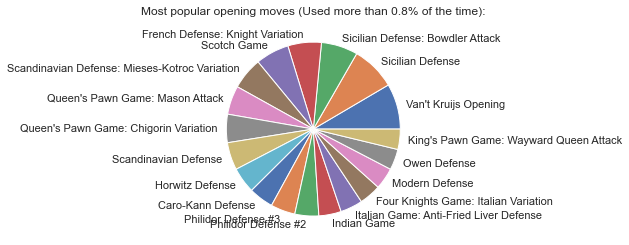

In [10]:
#grab lebels a number of occurences for each label
opening_moves_set = game_data['opening_name'].value_counts()
#remove least popular moves
opening_moves_set = opening_moves_set[opening_moves_set.gt(160)]
#show pie chart
plt.pie(opening_moves_set, labels = opening_moves_set.keys())
plt.title('Most popular opening moves (Used more than 0.8% of the time):')
plt.show()

## Comparing the most popular opening moves compared to their win rate

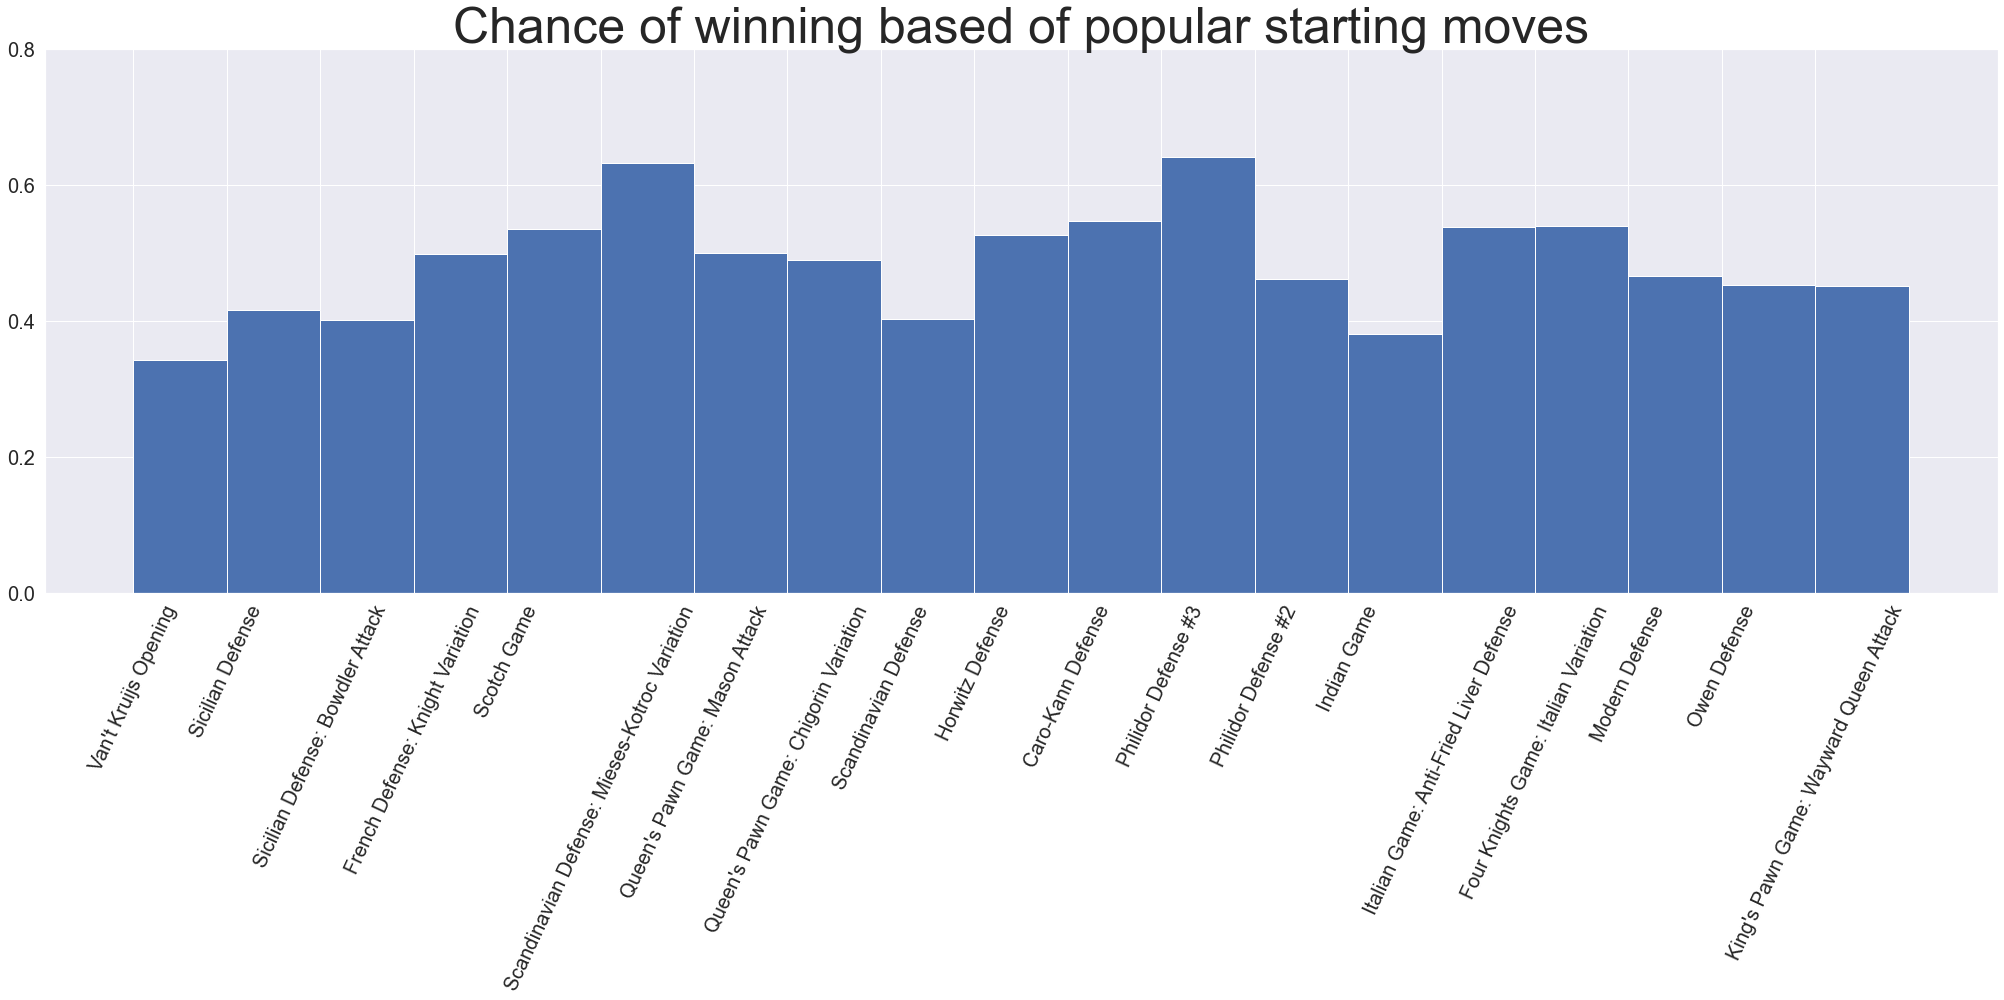

In [11]:
#most popular opening moves vs wins with those moves
temp = game_data[game_data['winner'] == 'white'] #show only winning games for the openning move
temp = temp[temp['opening_name'].isin(opening_moves_set.keys())] #remove games with non-popular starting moves
winning_opening_moves_set = temp['opening_name'].value_counts()
percents = pd.Series(float)
index = opening_moves_set.keys()
flag = False
for key in index:
    #print(percents.index.max())
    val = float(winning_opening_moves_set.get(key)) / float(opening_moves_set.get(key))
    if (flag):
        percents.loc[percents.index.max()+1] = val
    else:
        flag = True
        percents.loc[percents.index.max()] = val
percents.index = index
plt.figure(figsize=(35,10))
plt.bar(range(1, 20), percents, align='edge', width=1)
plt.yticks(np.linspace(0,1,5,endpoint=False), fontsize=20)
plt.xticks(range(1, 20), percents.keys(), rotation=65, fontsize=20)
plt.title('Chance of winning based of popular starting moves', fontsize=50)
plt.show()

In [6]:
## model cell ###

x_train, x_test, y_train, y_test = train_test_split(incoded_values, winners, test_size=0.30, random_state = 0)  
# initializes and runs the decision tree
cart = DecisionTreeClassifier()
cart.fit(x_train, y_train)

y_pred = cart.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("confusion_matrix")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.5900631439016284
confusion_matrix
[[1634  136  987]
 [ 101   49  118]
 [ 990  135 1868]]


In [7]:
# y_pred = cart.predict(incoded_values)
# incoded_values['victory_status'] = y_pred
# print(y_pred)

In [8]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

x_train, x_test, y_train, y_test = train_test_split(incoded_values, winners, test_size=0.30, random_state = 0)  
# initializes and runs the decision tree
wcart = DecisionTreeClassifier()
wcart.fit(x_train, y_train)

y_pred = wcart.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# print("confusion_matrix")
# print(confusion_matrix(y_test, y_pred))

x_train, x_test, y_train, y_test = train_test_split(incoded_values, winners, test_size=0.30, random_state = 0)  
# initializes and runs the decision tree
wcart = MLPClassifier()
wcart.fit(x_train, y_train)

y_pred = wcart.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

x_train, x_test, y_train, y_test = train_test_split(incoded_values, winners, test_size=0.30, random_state = 0)  
# initializes and runs the decision tree
wcart = RandomForestClassifier()
wcart.fit(x_train, y_train)

y_pred = wcart.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

x_train, x_test, y_train, y_test = train_test_split(incoded_values, winners, test_size=0.30, random_state = 0)  
# initializes and runs the decision tree
wcart = AdaBoostClassifier()
wcart.fit(x_train, y_train)

y_pred = wcart.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.5938850116317713


C:\Users\Theodore\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy: 0.49268860086407446


<ipython-input-8-a7ae227e3c3c>:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  wcart.fit(x_train, y_train)


Accuracy: 0.6543702226653373


C:\Users\Theodore\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy: 0.6462279827185111


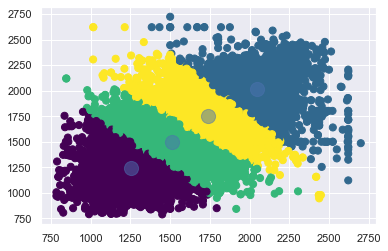

In [9]:
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()  # for plot styling
x= game_data[['white_rating','black_rating']]


kmeans = KMeans(n_clusters=4)
kmeans.fit(x)
y_kmeans = kmeans.predict(x)
x=np.array(x)
plt.scatter(x[:, 0], x[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], cmap='viridis', s=200, alpha=0.5);